In [1]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
import h5py
from tqdm import tqdm
import sys
from config import config
from matplotlib import pyplot as plt

ANNO_FILE = './annotations/person_keypoints_train2017.json'
IMG_DIR = './train2017'

In [2]:
coco = COCO(ANNO_FILE)
img_ids = list(coco.imgs.keys())

print(f"Preparing {len(img_ids)} images for training...")

loading annotations into memory...
Done (t=8.41s)
creating index...
index created!
Preparing 118287 images for training...


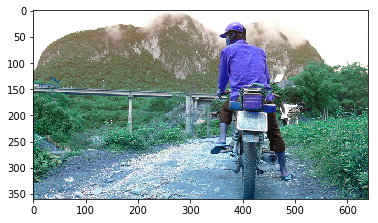

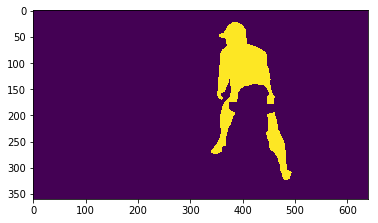

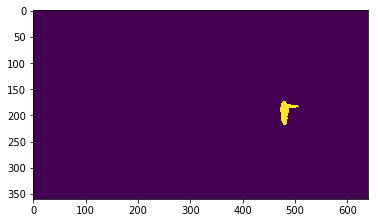

In [3]:
img_id = img_ids[0]
filepath = os.path.join(IMG_DIR, coco.imgs[img_id]['file_name'])
img = cv2.imread(filepath)
h, w, c = img.shape

plt.figure()
plt.imshow(img)

crowd_mask = np.zeros((h, w), dtype='bool')
unannotated_mask = np.zeros((h,w), dtype='bool')
instance_masks = []
keypoints = []

img_anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))

# if len(img_anns) == 0:
# #     continue
for anno in img_anns:
#     print(anno['area'])
#     if anno['area']==0:
#         continue

    mask = coco.annToMask(anno)
    plt.figure()
    plt.imshow(mask)

    # if crowd, don't compute loss
    if anno['iscrowd'] == 1:
        crowd_mask = np.logical_or(crowd_mask, mask)
    # if tiny instance, don't compute loss
    elif anno['num_keypoints'] == 0:
        unannotated_mask = np.logical_or(unannotated_mask, mask)
        instance_masks.append(mask)
        keypoints.append(anno['keypoints'])
    else:
        instance_masks.append(mask)
        keypoints.append(anno['keypoints'])

# Construct encoding:

encoding = np.argmax(np.stack([np.zeros((h,w))]+instance_masks, axis=-1), axis=-1).astype('uint8')
encoding = np.unpackbits(np.expand_dims(encoding, axis=-1), axis=-1)
# No image has more than 63 instance annotations, so the first 2 channels are zeros
encoding[:,:,0] = unannotated_mask.astype('uint8')
encoding[:,:,1] = crowd_mask.astype('uint8')
encoding = np.packbits(encoding, axis=-1)